Will Munson - Quantitative Researcher - LinkedIn

In [2]:
pip install quandl # If you run into a ModuleNotFoundError, you need to install the module first.

Note: you may need to restart the kernel to use updated packages.


Writing a class to store tick data

In [3]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		 # Keep track of symbols, timestamps, open and close prices, and total volume.
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

Writing a class to store market data

In [4]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

Writing a class to generate sources of market data

In [5]:
class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        # Keep track of symbols, ticks, and the start and end data 
        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        import quandl # Quandl makes it easier to obtain financial data

        # Update your Quandl API key here...
        QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'
        quandl.ApiConfig.api_key = QUANDL_API_KEY
        df = quandl.get(self.symbol, start_date=self.start, end_date=self.end)
        return df

    def run(self):
        if self.df is None: # If there is no dataframe available, 
            self.df = self.fetch_historical_prices() #Run fetch_historical_prices() again. 

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks) # calculate the total number of ticks 

        # Print out each tick one-by-one. 
        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)

Writing the order class

In [6]:
class Order(object):
    def __init__(self, timestamp, symbol, 
        qty, is_buy, is_market_order, 
        price=0
    ):
        # Keep track of timestamps, symbols, quantity, prices, buys, orders, and if they're filled
        self.timestamp = timestamp
        self.symbol = symbol
        self.qty = qty
        self.price = price
        self.is_buy = is_buy
        self.is_market_order = is_market_order
        self.is_filled = False
        self.filled_price = 0
        self.filled_time = None
        self.filled_qty = 0

Writing a class to keep track of positions

In [7]:
class Position(object):
    def __init__(self, symbol=''):
        #Keep track of symbols, buys and sells, profit and loss, and position value. 
        self.symbol = symbol
        self.buys = self.sells = self.net = 0
        self.rpnl = 0
        self.position_value = 0

    def on_position_event(self, is_buy, qty, price):
        #Check if it's a buy or sell. 
        if is_buy:
            self.buys += qty
        else:
            self.sells += qty

        #Calculate changes in profit
        self.net = self.buys - self.sells
        changed_value = qty * price * (-1 if is_buy else 1)
        self.position_value += changed_value

        if self.net == 0:
            self.rpnl = self.position_value
            self.position_value = 0

    #Keep an eye on any unrealized profit and loss
    def calculate_unrealized_pnl(self, price):
        if self.net == 0:
            return 0

        market_value = self.net * price
        upnl = self.position_value + market_value
        return upnl

Writing an abstract strategy class

In [8]:
from abc import abstractmethod # Abstract methods can be declared but not implemented

class Strategy:
    def __init__(self, send_order_event_handler):
        self.send_order_event_handler = send_order_event_handler

    @abstractmethod
    def on_tick_event(self, market_data):
        raise NotImplementedError('Method is required!')

    @abstractmethod
    def on_position_event(self, positions):
        raise NotImplementedError('Method is required!')

    def send_market_order(self, symbol, qty, is_buy, timestamp):
        if self.send_order_event_handler:
            order = Order(
                timestamp,
                symbol,
                qty,
                is_buy,
                is_market_order=True,
                price=0,
            )
            self.send_order_event_handler(order)

Writing a mean-reverting strategy class

In [9]:
import pandas as pd # Used for high-level indexing processes

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    #As any data scientist/statistician should know,
    # remember to check your z-score for any potential anomalies.
    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

Binding our modules with a backtesting engine

In [10]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
        #Keep track of data sources and trade quantity
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

            # Print the data, and sort by date (There's a lot of data here)
			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

Running our backtesting engine

In [11]:
engine = BacktestEngine( # Data over the course of 3 years
    'WIKI/AAPL', 1,
    start='2015-01-01',
    end='2017-12-31'
)

In [12]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5, # Buy limit
    sell_threshold=1.5 # Sell limit
)

Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107.03 close: 105.99
2015-01-20 TICK WIKI/AAPL open: 107.84 close: 108.72
2015-01-21 TICK WIKI/AAPL open: 108.95 close: 109.55
2015-01-22 TICK WIKI/AAPL open: 110.26 close: 112.4
2015-01-23 TICK WIKI/AAPL open: 112.3 close: 112.98
2015-01-26 TICK WIKI/AAPL open: 113.74 close: 113.1
2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015

2015-06-05 POSITION value:-126.560 upnl:2.090 rpnl:3.400
2015-06-08 TICK WIKI/AAPL open: 128.9 close: 127.8
2015-06-08 POSITION value:-126.560 upnl:1.240 rpnl:3.400
2015-06-09 TICK WIKI/AAPL open: 126.7 close: 127.42
2015-06-09 POSITION value:-126.560 upnl:0.860 rpnl:3.400
2015-06-10 TICK WIKI/AAPL open: 127.92 close: 128.88
2015-06-10 POSITION value:-126.560 upnl:2.320 rpnl:3.400
2015-06-11 TICK WIKI/AAPL open: 129.18 close: 128.59
2015-06-11 POSITION value:-126.560 upnl:2.030 rpnl:3.400
2015-06-12 TICK WIKI/AAPL open: 128.185 close: 127.17
2015-06-12 POSITION value:-126.560 upnl:0.610 rpnl:3.400
2015-06-15 TICK WIKI/AAPL open: 126.1 close: 126.92
2015-06-15 POSITION value:-126.560 upnl:0.360 rpnl:3.400
2015-06-16 TICK WIKI/AAPL open: 127.03 close: 127.6
2015-06-16 POSITION value:-126.560 upnl:1.040 rpnl:3.400
2015-06-17 TICK WIKI/AAPL open: 127.72 close: 127.3
2015-06-17 POSITION value:-126.560 upnl:0.740 rpnl:3.400
2015-06-18 TICK WIKI/AAPL open: 127.23 close: 127.88
2015-06-18 POSI

2015-10-13 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-14 TICK WIKI/AAPL open: 111.29 close: 110.21
2015-10-14 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-15 TICK WIKI/AAPL open: 110.93 close: 111.86
2015-10-15 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-16 TICK WIKI/AAPL open: 111.78 close: 111.04
2015-10-16 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-19 TICK WIKI/AAPL open: 110.8 close: 111.73
2015-10-19 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-20 TICK WIKI/AAPL open: 111.34 close: 113.77
2015-10-20 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-21 TICK WIKI/AAPL open: 114.0 close: 113.76
2015-10-21 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-22 TICK WIKI/AAPL open: 114.33 close: 115.5
2015-10-22 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-23 TICK WIKI/AAPL open: 116.7 close: 119.08
2015-10-23 SELL signal
2015-10-23 ORDER SELL WIKI/AAPL 1
2015-10-23 POSITION value:0.000 upnl:0.000 rpnl:2.560
2015-10-26 TICK WIKI/AAPL open: 118.0

2016-03-02 FILLED SELL 1 WIKI/AAPL at 100.51
2016-03-02 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-03 TICK WIKI/AAPL open: 100.58 close: 101.5
2016-03-03 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-04 TICK WIKI/AAPL open: 102.37 close: 103.01
2016-03-04 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-07 TICK WIKI/AAPL open: 102.39 close: 101.87
2016-03-07 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-08 TICK WIKI/AAPL open: 100.78 close: 101.03
2016-03-08 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-09 TICK WIKI/AAPL open: 101.31 close: 101.12
2016-03-09 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-10 TICK WIKI/AAPL open: 101.41 close: 101.17
2016-03-10 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-11 TICK WIKI/AAPL open: 102.24 close: 102.26
2016-03-11 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-14 TICK WIKI/AAPL open: 101.91 close: 102.52
2016-03-14 POSITION value:0.000 upnl:0.000 rpnl:6.720
2016-03-15 TICK WIKI/AAPL open: 103.96 close: 

2016-07-12 TICK WIKI/AAPL open: 97.17 close: 97.42
2016-07-12 POSITION value:0.000 upnl:0.000 rpnl:-3.350
2016-07-13 TICK WIKI/AAPL open: 97.41 close: 96.87
2016-07-13 POSITION value:0.000 upnl:0.000 rpnl:-3.350
2016-07-14 TICK WIKI/AAPL open: 97.39 close: 98.79
2016-07-14 SELL signal
2016-07-14 ORDER SELL WIKI/AAPL 1
2016-07-14 POSITION value:0.000 upnl:0.000 rpnl:-3.350
2016-07-15 TICK WIKI/AAPL open: 98.92 close: 98.78
2016-07-15 FILLED SELL 1 WIKI/AAPL at 98.92
2016-07-15 POSITION value:98.920 upnl:0.140 rpnl:-3.350
2016-07-18 TICK WIKI/AAPL open: 98.7 close: 99.83
2016-07-18 POSITION value:98.920 upnl:-0.910 rpnl:-3.350
2016-07-19 TICK WIKI/AAPL open: 99.56 close: 99.87
2016-07-19 POSITION value:98.920 upnl:-0.950 rpnl:-3.350
2016-07-20 TICK WIKI/AAPL open: 100.0 close: 99.96
2016-07-20 POSITION value:98.920 upnl:-1.040 rpnl:-3.350
2016-07-21 TICK WIKI/AAPL open: 99.83 close: 99.43
2016-07-21 POSITION value:98.920 upnl:-0.510 rpnl:-3.350
2016-07-22 TICK WIKI/AAPL open: 99.26 close

2016-11-28 TICK WIKI/AAPL open: 111.43 close: 111.57
2016-11-28 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-11-29 TICK WIKI/AAPL open: 110.78 close: 111.46
2016-11-29 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-11-30 TICK WIKI/AAPL open: 111.56 close: 110.52
2016-11-30 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-01 TICK WIKI/AAPL open: 110.365 close: 109.49
2016-12-01 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-02 TICK WIKI/AAPL open: 109.17 close: 109.9
2016-12-02 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-05 TICK WIKI/AAPL open: 110.0 close: 109.11
2016-12-05 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-06 TICK WIKI/AAPL open: 109.5 close: 109.95
2016-12-06 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-07 TICK WIKI/AAPL open: 109.26 close: 111.03
2016-12-07 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-08 TICK WIKI/AAPL open: 110.86 close: 112.12
2016-12-08 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-09 TICK WIKI/AAPL open: 112.31 

2017-04-19 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-04-20 TICK WIKI/AAPL open: 141.22 close: 142.44
2017-04-20 SELL signal
2017-04-20 ORDER SELL WIKI/AAPL 1
2017-04-20 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-04-21 TICK WIKI/AAPL open: 142.44 close: 142.27
2017-04-21 FILLED SELL 1 WIKI/AAPL at 142.44
2017-04-21 POSITION value:142.440 upnl:0.170 rpnl:3.835
2017-04-24 TICK WIKI/AAPL open: 143.5 close: 143.64
2017-04-24 POSITION value:142.440 upnl:-1.200 rpnl:3.835
2017-04-25 TICK WIKI/AAPL open: 143.91 close: 144.54
2017-04-25 POSITION value:142.440 upnl:-2.100 rpnl:3.835
2017-04-26 TICK WIKI/AAPL open: 144.47 close: 143.6508
2017-04-26 POSITION value:142.440 upnl:-1.211 rpnl:3.835
2017-04-27 TICK WIKI/AAPL open: 143.9225 close: 143.79
2017-04-27 POSITION value:142.440 upnl:-1.350 rpnl:3.835
2017-04-28 TICK WIKI/AAPL open: 144.09 close: 143.65
2017-04-28 POSITION value:142.440 upnl:-1.210 rpnl:3.835
2017-05-01 TICK WIKI/AAPL open: 145.1 close: 146.6
2017-05-01 POSITION valu

2017-08-15 POSITION value:-156.600 upnl:5.000 rpnl:7.160
2017-08-16 TICK WIKI/AAPL open: 161.94 close: 160.95
2017-08-16 POSITION value:-156.600 upnl:4.350 rpnl:7.160
2017-08-17 TICK WIKI/AAPL open: 160.52 close: 157.87
2017-08-17 POSITION value:-156.600 upnl:1.270 rpnl:7.160
2017-08-18 TICK WIKI/AAPL open: 157.86 close: 157.5
2017-08-18 POSITION value:-156.600 upnl:0.900 rpnl:7.160
2017-08-21 TICK WIKI/AAPL open: 157.5 close: 157.21
2017-08-21 POSITION value:-156.600 upnl:0.610 rpnl:7.160
2017-08-22 TICK WIKI/AAPL open: 158.23 close: 159.78
2017-08-22 POSITION value:-156.600 upnl:3.180 rpnl:7.160
2017-08-23 TICK WIKI/AAPL open: 159.07 close: 159.98
2017-08-23 POSITION value:-156.600 upnl:3.380 rpnl:7.160
2017-08-24 TICK WIKI/AAPL open: 160.43 close: 159.27
2017-08-24 POSITION value:-156.600 upnl:2.670 rpnl:7.160
2017-08-25 TICK WIKI/AAPL open: 159.65 close: 159.86
2017-08-25 POSITION value:-156.600 upnl:3.260 rpnl:7.160
2017-08-28 TICK WIKI/AAPL open: 160.14 close: 161.47
2017-08-28 P

2017-11-30 TICK WIKI/AAPL open: 170.43 close: 171.85
2017-11-30 FILLED BUY 1 WIKI/AAPL at 170.43
2017-11-30 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-01 TICK WIKI/AAPL open: 169.95 close: 171.05
2017-12-01 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-04 TICK WIKI/AAPL open: 172.48 close: 169.8
2017-12-04 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-05 TICK WIKI/AAPL open: 169.06 close: 169.64
2017-12-05 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-06 TICK WIKI/AAPL open: 167.5 close: 169.01
2017-12-06 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-07 TICK WIKI/AAPL open: 169.03 close: 169.452
2017-12-07 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-08 TICK WIKI/AAPL open: 170.49 close: 169.37
2017-12-08 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-11 TICK WIKI/AAPL open: 169.2 close: 172.67
2017-12-11 SELL signal
2017-12-11 ORDER SELL WIKI/AAPL 1
2017-12-11 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-12 TICK WIKI/AAPL open: 172.1

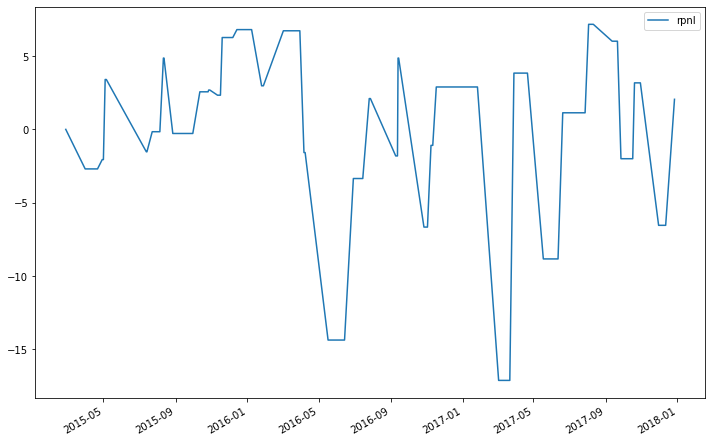

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt # machine learning library used to create datasets and plots

engine.df_rpnl.plot(figsize=(12, 8));

Multiple runs of the backtest engine

In [14]:
THRESHOLDS = [
    (-0.5, 0.5),
    (-1.5, 1.5),
    (-2.5, 2.0),
    (-1.5, 2.5),
]

Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107.03 close: 105.99
2015-01-20 TICK WIKI/AAPL open: 107.84 close: 108.72
2015-01-21 TICK WIKI/AAPL open: 108.95 close: 109.55
2015-01-22 TICK WIKI/AAPL open: 110.26 close: 112.4
2015-01-23 TICK WIKI/AAPL open: 112.3 close: 112.98
2015-01-26 TICK WIKI/AAPL open: 113.74 close: 113.1
2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015

2015-05-15 FILLED SELL 1 WIKI/AAPL at 129.07
2015-05-15 POSITION value:0.000 upnl:0.000 rpnl:3.470
2015-05-18 TICK WIKI/AAPL open: 128.38 close: 130.19
2015-05-18 SELL signal
2015-05-18 ORDER SELL WIKI/AAPL 1
2015-05-18 POSITION value:0.000 upnl:0.000 rpnl:3.470
2015-05-19 TICK WIKI/AAPL open: 130.69 close: 130.07
2015-05-19 FILLED SELL 1 WIKI/AAPL at 130.69
2015-05-19 POSITION value:130.690 upnl:0.620 rpnl:3.470
2015-05-20 TICK WIKI/AAPL open: 130.0 close: 130.06
2015-05-20 POSITION value:130.690 upnl:0.630 rpnl:3.470
2015-05-21 TICK WIKI/AAPL open: 130.07 close: 131.39
2015-05-21 POSITION value:130.690 upnl:-0.700 rpnl:3.470
2015-05-22 TICK WIKI/AAPL open: 131.6 close: 132.54
2015-05-22 POSITION value:130.690 upnl:-1.850 rpnl:3.470
2015-05-26 TICK WIKI/AAPL open: 132.6 close: 129.62
2015-05-26 BUY signal
2015-05-26 ORDER BUY WIKI/AAPL 1
2015-05-26 POSITION value:130.690 upnl:1.070 rpnl:3.470
2015-05-27 TICK WIKI/AAPL open: 130.34 close: 132.045
2015-05-27 FILLED BUY 1 WIKI/AAPL at 13

2015-09-08 TICK WIKI/AAPL open: 111.65 close: 112.31
2015-09-08 POSITION value:112.490 upnl:0.180 rpnl:2.250
2015-09-09 TICK WIKI/AAPL open: 113.76 close: 110.15
2015-09-09 BUY signal
2015-09-09 ORDER BUY WIKI/AAPL 1
2015-09-09 POSITION value:112.490 upnl:2.340 rpnl:2.250
2015-09-10 TICK WIKI/AAPL open: 110.27 close: 112.57
2015-09-10 FILLED BUY 1 WIKI/AAPL at 110.27
2015-09-10 SELL signal
2015-09-10 ORDER SELL WIKI/AAPL 1
2015-09-10 POSITION value:0.000 upnl:0.000 rpnl:2.220
2015-09-11 TICK WIKI/AAPL open: 111.79 close: 114.21
2015-09-11 FILLED SELL 1 WIKI/AAPL at 111.79
2015-09-11 POSITION value:111.790 upnl:-2.420 rpnl:2.220
2015-09-14 TICK WIKI/AAPL open: 116.58 close: 115.31
2015-09-14 POSITION value:111.790 upnl:-3.520 rpnl:2.220
2015-09-15 TICK WIKI/AAPL open: 115.93 close: 116.28
2015-09-15 POSITION value:111.790 upnl:-4.490 rpnl:2.220
2015-09-16 TICK WIKI/AAPL open: 116.25 close: 116.41
2015-09-16 POSITION value:111.790 upnl:-4.620 rpnl:2.220
2015-09-17 TICK WIKI/AAPL open: 11

2015-12-28 TICK WIKI/AAPL open: 107.59 close: 106.82
2015-12-28 POSITION value:109.000 upnl:2.180 rpnl:-1.510
2015-12-29 TICK WIKI/AAPL open: 106.96 close: 108.74
2015-12-29 POSITION value:109.000 upnl:0.260 rpnl:-1.510
2015-12-30 TICK WIKI/AAPL open: 108.58 close: 107.32
2015-12-30 BUY signal
2015-12-30 ORDER BUY WIKI/AAPL 1
2015-12-30 POSITION value:109.000 upnl:1.680 rpnl:-1.510
2015-12-31 TICK WIKI/AAPL open: 107.01 close: 105.26
2015-12-31 FILLED BUY 1 WIKI/AAPL at 107.01
2015-12-31 BUY signal
2015-12-31 ORDER BUY WIKI/AAPL 1
2015-12-31 POSITION value:0.000 upnl:0.000 rpnl:1.990
2016-01-04 TICK WIKI/AAPL open: 102.61 close: 105.35
2016-01-04 FILLED BUY 1 WIKI/AAPL at 102.61
2016-01-04 SELL signal
2016-01-04 ORDER SELL WIKI/AAPL 1
2016-01-04 POSITION value:-102.610 upnl:2.740 rpnl:1.990
2016-01-05 TICK WIKI/AAPL open: 105.75 close: 102.71
2016-01-05 FILLED SELL 1 WIKI/AAPL at 105.75
2016-01-05 BUY signal
2016-01-05 ORDER BUY WIKI/AAPL 1
2016-01-05 POSITION value:0.000 upnl:0.000 rp

2016-04-13 FILLED SELL 1 WIKI/AAPL at 110.8
2016-04-13 POSITION value:110.800 upnl:-1.240 rpnl:1.040
2016-04-14 TICK WIKI/AAPL open: 111.62 close: 112.1
2016-04-14 POSITION value:110.800 upnl:-1.300 rpnl:1.040
2016-04-15 TICK WIKI/AAPL open: 112.11 close: 109.85
2016-04-15 BUY signal
2016-04-15 ORDER BUY WIKI/AAPL 1
2016-04-15 POSITION value:110.800 upnl:0.950 rpnl:1.040
2016-04-18 TICK WIKI/AAPL open: 108.89 close: 107.48
2016-04-18 FILLED BUY 1 WIKI/AAPL at 108.89
2016-04-18 BUY signal
2016-04-18 ORDER BUY WIKI/AAPL 1
2016-04-18 POSITION value:0.000 upnl:0.000 rpnl:1.910
2016-04-19 TICK WIKI/AAPL open: 107.88 close: 106.91
2016-04-19 FILLED BUY 1 WIKI/AAPL at 107.88
2016-04-19 POSITION value:-107.880 upnl:-0.970 rpnl:1.910
2016-04-20 TICK WIKI/AAPL open: 106.64 close: 107.13
2016-04-20 POSITION value:-107.880 upnl:-0.750 rpnl:1.910
2016-04-21 TICK WIKI/AAPL open: 106.93 close: 105.97
2016-04-21 POSITION value:-107.880 upnl:-1.910 rpnl:1.910
2016-04-22 TICK WIKI/AAPL open: 105.01 clos

2016-08-03 TICK WIKI/AAPL open: 104.81 close: 105.79
2016-08-03 FILLED BUY 1 WIKI/AAPL at 104.81
2016-08-03 POSITION value:0.000 upnl:0.000 rpnl:-0.620
2016-08-04 TICK WIKI/AAPL open: 105.58 close: 105.87
2016-08-04 POSITION value:0.000 upnl:0.000 rpnl:-0.620
2016-08-05 TICK WIKI/AAPL open: 106.27 close: 107.48
2016-08-05 SELL signal
2016-08-05 ORDER SELL WIKI/AAPL 1
2016-08-05 POSITION value:0.000 upnl:0.000 rpnl:-0.620
2016-08-08 TICK WIKI/AAPL open: 107.52 close: 108.37
2016-08-08 FILLED SELL 1 WIKI/AAPL at 107.52
2016-08-08 POSITION value:107.520 upnl:-0.850 rpnl:-0.620
2016-08-09 TICK WIKI/AAPL open: 108.23 close: 108.81
2016-08-09 POSITION value:107.520 upnl:-1.290 rpnl:-0.620
2016-08-10 TICK WIKI/AAPL open: 108.71 close: 108.0
2016-08-10 BUY signal
2016-08-10 ORDER BUY WIKI/AAPL 1
2016-08-10 POSITION value:107.520 upnl:-0.480 rpnl:-0.620
2016-08-11 TICK WIKI/AAPL open: 108.52 close: 107.93
2016-08-11 FILLED BUY 1 WIKI/AAPL at 108.52
2016-08-11 POSITION value:0.000 upnl:0.000 rpn

2016-11-29 POSITION value:106.700 upnl:-4.760 rpnl:0.750
2016-11-30 TICK WIKI/AAPL open: 111.56 close: 110.52
2016-11-30 BUY signal
2016-11-30 ORDER BUY WIKI/AAPL 1
2016-11-30 POSITION value:106.700 upnl:-3.820 rpnl:0.750
2016-12-01 TICK WIKI/AAPL open: 110.365 close: 109.49
2016-12-01 FILLED BUY 1 WIKI/AAPL at 110.365
2016-12-01 BUY signal
2016-12-01 ORDER BUY WIKI/AAPL 1
2016-12-01 POSITION value:0.000 upnl:0.000 rpnl:-3.665
2016-12-02 TICK WIKI/AAPL open: 109.17 close: 109.9
2016-12-02 FILLED BUY 1 WIKI/AAPL at 109.17
2016-12-02 POSITION value:-109.170 upnl:0.730 rpnl:-3.665
2016-12-05 TICK WIKI/AAPL open: 110.0 close: 109.11
2016-12-05 POSITION value:-109.170 upnl:-0.060 rpnl:-3.665
2016-12-06 TICK WIKI/AAPL open: 109.5 close: 109.95
2016-12-06 SELL signal
2016-12-06 ORDER SELL WIKI/AAPL 1
2016-12-06 POSITION value:-109.170 upnl:0.780 rpnl:-3.665
2016-12-07 TICK WIKI/AAPL open: 109.26 close: 111.03
2016-12-07 FILLED SELL 1 WIKI/AAPL at 109.26
2016-12-07 SELL signal
2016-12-07 ORDER

2017-03-28 POSITION value:-141.500 upnl:2.300 rpnl:1.415
2017-03-29 TICK WIKI/AAPL open: 143.68 close: 144.12
2017-03-29 FILLED SELL 1 WIKI/AAPL at 143.68
2017-03-29 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-03-30 TICK WIKI/AAPL open: 144.19 close: 143.93
2017-03-30 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-03-31 TICK WIKI/AAPL open: 143.72 close: 143.66
2017-03-31 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-04-03 TICK WIKI/AAPL open: 143.71 close: 143.7
2017-04-03 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-04-04 TICK WIKI/AAPL open: 143.25 close: 144.77
2017-04-04 SELL signal
2017-04-04 ORDER SELL WIKI/AAPL 1
2017-04-04 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-04-05 TICK WIKI/AAPL open: 144.22 close: 144.02
2017-04-05 FILLED SELL 1 WIKI/AAPL at 144.22
2017-04-05 BUY signal
2017-04-05 ORDER BUY WIKI/AAPL 1
2017-04-05 POSITION value:144.220 upnl:0.200 rpnl:2.180
2017-04-06 TICK WIKI/AAPL open: 144.29 close: 143.66
2017-04-06 FILLED BUY 1 WIKI/AAPL at 144.29
2

2017-07-17 TICK WIKI/AAPL open: 148.82 close: 149.56
2017-07-17 POSITION value:143.020 upnl:-6.540 rpnl:0.260
2017-07-18 TICK WIKI/AAPL open: 149.2 close: 150.08
2017-07-18 POSITION value:143.020 upnl:-7.060 rpnl:0.260
2017-07-19 TICK WIKI/AAPL open: 150.48 close: 151.02
2017-07-19 POSITION value:143.020 upnl:-8.000 rpnl:0.260
2017-07-20 TICK WIKI/AAPL open: 151.5 close: 150.34
2017-07-20 BUY signal
2017-07-20 ORDER BUY WIKI/AAPL 1
2017-07-20 POSITION value:143.020 upnl:-7.320 rpnl:0.260
2017-07-21 TICK WIKI/AAPL open: 149.99 close: 150.27
2017-07-21 FILLED BUY 1 WIKI/AAPL at 149.99
2017-07-21 POSITION value:0.000 upnl:0.000 rpnl:-6.970
2017-07-24 TICK WIKI/AAPL open: 150.58 close: 152.09
2017-07-24 SELL signal
2017-07-24 ORDER SELL WIKI/AAPL 1
2017-07-24 POSITION value:0.000 upnl:0.000 rpnl:-6.970
2017-07-25 TICK WIKI/AAPL open: 151.8 close: 152.74
2017-07-25 FILLED SELL 1 WIKI/AAPL at 151.8
2017-07-25 POSITION value:151.800 upnl:-0.940 rpnl:-6.970
2017-07-26 TICK WIKI/AAPL open: 153.

2017-11-03 POSITION value:0.000 upnl:0.000 rpnl:-3.750
2017-11-06 TICK WIKI/AAPL open: 172.365 close: 174.25
2017-11-06 FILLED SELL 1 WIKI/AAPL at 172.365
2017-11-06 POSITION value:172.365 upnl:-1.885 rpnl:-3.750
2017-11-07 TICK WIKI/AAPL open: 173.91 close: 174.81
2017-11-07 POSITION value:172.365 upnl:-2.445 rpnl:-3.750
2017-11-09 TICK WIKI/AAPL open: 175.11 close: 175.88
2017-11-09 POSITION value:172.365 upnl:-3.515 rpnl:-3.750
2017-11-10 TICK WIKI/AAPL open: 175.11 close: 174.67
2017-11-10 BUY signal
2017-11-10 ORDER BUY WIKI/AAPL 1
2017-11-10 POSITION value:172.365 upnl:-2.305 rpnl:-3.750
2017-11-13 TICK WIKI/AAPL open: 173.5 close: 173.97
2017-11-13 FILLED BUY 1 WIKI/AAPL at 173.5
2017-11-13 BUY signal
2017-11-13 ORDER BUY WIKI/AAPL 1
2017-11-13 POSITION value:0.000 upnl:0.000 rpnl:-1.135
2017-11-14 TICK WIKI/AAPL open: 173.04 close: 171.34
2017-11-14 FILLED BUY 1 WIKI/AAPL at 173.04
2017-11-14 POSITION value:-173.040 upnl:-1.700 rpnl:-1.135
2017-11-15 TICK WIKI/AAPL open: 169.97

2015-03-30 SELL signal
2015-03-30 ORDER SELL WIKI/AAPL 1
2015-03-30 POSITION value:-128.785 upnl:-2.415 rpnl:0.000
2015-03-31 TICK WIKI/AAPL open: 126.09 close: 124.43
2015-03-31 FILLED SELL 1 WIKI/AAPL at 126.09
2015-03-31 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-01 TICK WIKI/AAPL open: 124.82 close: 124.25
2015-04-01 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-02 TICK WIKI/AAPL open: 125.03 close: 125.32
2015-04-02 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-06 TICK WIKI/AAPL open: 124.47 close: 127.35
2015-04-06 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-07 TICK WIKI/AAPL open: 127.64 close: 126.01
2015-04-07 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-08 TICK WIKI/AAPL open: 125.85 close: 125.6
2015-04-08 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-09 TICK WIKI/AAPL open: 125.85 close: 126.56
2015-04-09 POSITION value:0.000 upnl:0.000 rpnl:-2.695
2015-04-10 TICK WIKI/AAPL open: 125.95 close: 127.1
2015-04-10 POSITION value:0.000 u

2015-08-20 TICK WIKI/AAPL open: 114.08 close: 112.65
2015-08-20 POSITION value:-112.530 upnl:0.120 rpnl:4.860
2015-08-21 TICK WIKI/AAPL open: 110.43 close: 105.76
2015-08-21 POSITION value:-112.530 upnl:-6.770 rpnl:4.860
2015-08-24 TICK WIKI/AAPL open: 94.87 close: 103.12
2015-08-24 POSITION value:-112.530 upnl:-9.410 rpnl:4.860
2015-08-25 TICK WIKI/AAPL open: 111.11 close: 103.74
2015-08-25 POSITION value:-112.530 upnl:-8.790 rpnl:4.860
2015-08-26 TICK WIKI/AAPL open: 107.085 close: 109.69
2015-08-26 SELL signal
2015-08-26 ORDER SELL WIKI/AAPL 1
2015-08-26 POSITION value:-112.530 upnl:-2.840 rpnl:4.860
2015-08-27 TICK WIKI/AAPL open: 112.25 close: 112.92
2015-08-27 FILLED SELL 1 WIKI/AAPL at 112.25
2015-08-27 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-08-28 TICK WIKI/AAPL open: 112.17 close: 113.29
2015-08-28 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-08-31 TICK WIKI/AAPL open: 112.13 close: 112.76
2015-08-31 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-01 TICK WIKI

2016-01-04 TICK WIKI/AAPL open: 102.61 close: 105.35
2016-01-04 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-05 TICK WIKI/AAPL open: 105.75 close: 102.71
2016-01-05 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-06 TICK WIKI/AAPL open: 100.56 close: 100.7
2016-01-06 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-07 TICK WIKI/AAPL open: 98.68 close: 96.45
2016-01-07 BUY signal
2016-01-07 ORDER BUY WIKI/AAPL 1
2016-01-07 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-08 TICK WIKI/AAPL open: 98.55 close: 96.96
2016-01-08 FILLED BUY 1 WIKI/AAPL at 98.55
2016-01-08 POSITION value:-98.550 upnl:-1.590 rpnl:6.800
2016-01-11 TICK WIKI/AAPL open: 98.97 close: 98.53
2016-01-11 POSITION value:-98.550 upnl:-0.020 rpnl:6.800
2016-01-12 TICK WIKI/AAPL open: 100.55 close: 99.96
2016-01-12 POSITION value:-98.550 upnl:1.410 rpnl:6.800
2016-01-13 TICK WIKI/AAPL open: 100.32 close: 97.39
2016-01-13 POSITION value:-98.550 upnl:-1.160 rpnl:6.800
2016-01-14 TICK WIKI/AAPL open: 97.96 close:

2016-05-31 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-01 TICK WIKI/AAPL open: 99.02 close: 98.46
2016-06-01 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-02 TICK WIKI/AAPL open: 97.6 close: 97.72
2016-06-02 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-03 TICK WIKI/AAPL open: 97.79 close: 97.92
2016-06-03 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-06 TICK WIKI/AAPL open: 97.99 close: 98.63
2016-06-06 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-07 TICK WIKI/AAPL open: 99.25 close: 99.03
2016-06-07 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-08 TICK WIKI/AAPL open: 99.02 close: 98.94
2016-06-08 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-09 TICK WIKI/AAPL open: 98.5 close: 99.65
2016-06-09 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-10 TICK WIKI/AAPL open: 98.53 close: 98.83
2016-06-10 POSITION value:0.000 upnl:0.000 rpnl:-14.360
2016-06-13 TICK WIKI/AAPL open: 98.69 close: 97.34
2016-06-13 BUY signal
2016-06-13 ORDER 

2016-10-05 POSITION value:108.730 upnl:-4.320 rpnl:4.860
2016-10-06 TICK WIKI/AAPL open: 113.7 close: 113.89
2016-10-06 POSITION value:108.730 upnl:-5.160 rpnl:4.860
2016-10-07 TICK WIKI/AAPL open: 114.31 close: 114.06
2016-10-07 POSITION value:108.730 upnl:-5.330 rpnl:4.860
2016-10-10 TICK WIKI/AAPL open: 115.02 close: 116.05
2016-10-10 POSITION value:108.730 upnl:-7.320 rpnl:4.860
2016-10-11 TICK WIKI/AAPL open: 117.7 close: 116.3
2016-10-11 POSITION value:108.730 upnl:-7.570 rpnl:4.860
2016-10-12 TICK WIKI/AAPL open: 117.35 close: 117.34
2016-10-12 POSITION value:108.730 upnl:-8.610 rpnl:4.860
2016-10-13 TICK WIKI/AAPL open: 116.79 close: 116.98
2016-10-13 POSITION value:108.730 upnl:-8.250 rpnl:4.860
2016-10-14 TICK WIKI/AAPL open: 117.88 close: 117.63
2016-10-14 POSITION value:108.730 upnl:-8.900 rpnl:4.860
2016-10-17 TICK WIKI/AAPL open: 117.33 close: 117.55
2016-10-17 POSITION value:108.730 upnl:-8.820 rpnl:4.860
2016-10-18 TICK WIKI/AAPL open: 118.18 close: 117.47
2016-10-18 PO

2017-02-24 POSITION value:121.670 upnl:-14.990 rpnl:2.890
2017-02-27 TICK WIKI/AAPL open: 137.14 close: 136.93
2017-02-27 POSITION value:121.670 upnl:-15.260 rpnl:2.890
2017-02-28 TICK WIKI/AAPL open: 137.08 close: 136.99
2017-02-28 POSITION value:121.670 upnl:-15.320 rpnl:2.890
2017-03-01 TICK WIKI/AAPL open: 137.89 close: 139.79
2017-03-01 POSITION value:121.670 upnl:-18.120 rpnl:2.890
2017-03-02 TICK WIKI/AAPL open: 140.0 close: 138.96
2017-03-02 BUY signal
2017-03-02 ORDER BUY WIKI/AAPL 1
2017-03-02 POSITION value:121.670 upnl:-17.290 rpnl:2.890
2017-03-03 TICK WIKI/AAPL open: 138.78 close: 139.78
2017-03-03 FILLED BUY 1 WIKI/AAPL at 138.78
2017-03-03 POSITION value:0.000 upnl:0.000 rpnl:-17.110
2017-03-06 TICK WIKI/AAPL open: 139.365 close: 139.34
2017-03-06 POSITION value:0.000 upnl:0.000 rpnl:-17.110
2017-03-07 TICK WIKI/AAPL open: 139.06 close: 139.52
2017-03-07 POSITION value:0.000 upnl:0.000 rpnl:-17.110
2017-03-08 TICK WIKI/AAPL open: 138.95 close: 139.0
2017-03-08 POSITION 

2017-07-07 TICK WIKI/AAPL open: 142.9 close: 144.18
2017-07-07 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-10 TICK WIKI/AAPL open: 144.11 close: 145.06
2017-07-10 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-11 TICK WIKI/AAPL open: 144.73 close: 145.53
2017-07-11 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-12 TICK WIKI/AAPL open: 145.87 close: 145.74
2017-07-12 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-13 TICK WIKI/AAPL open: 145.5 close: 147.77
2017-07-13 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-14 TICK WIKI/AAPL open: 147.97 close: 149.04
2017-07-14 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-17 TICK WIKI/AAPL open: 148.82 close: 149.56
2017-07-17 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-18 TICK WIKI/AAPL open: 149.2 close: 150.08
2017-07-18 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-19 TICK WIKI/AAPL open: 150.48 close: 151.02
2017-07-19 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-20 TICK WIKI/AAPL open: 151.5 cl

2017-12-01 TICK WIKI/AAPL open: 169.95 close: 171.05
2017-12-01 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-04 TICK WIKI/AAPL open: 172.48 close: 169.8
2017-12-04 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-05 TICK WIKI/AAPL open: 169.06 close: 169.64
2017-12-05 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-06 TICK WIKI/AAPL open: 167.5 close: 169.01
2017-12-06 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-07 TICK WIKI/AAPL open: 169.03 close: 169.452
2017-12-07 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-08 TICK WIKI/AAPL open: 170.49 close: 169.37
2017-12-08 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-11 TICK WIKI/AAPL open: 169.2 close: 172.67
2017-12-11 SELL signal
2017-12-11 ORDER SELL WIKI/AAPL 1
2017-12-11 POSITION value:0.000 upnl:0.000 rpnl:-6.540
2017-12-12 TICK WIKI/AAPL open: 172.15 close: 171.7
2017-12-12 FILLED SELL 1 WIKI/AAPL at 172.15
2017-12-12 POSITION value:172.150 upnl:0.450 rpnl:-6.540
2017-12-13 TICK WIKI/AAPL open: 172

2015-07-01 POSITION value:129.500 upnl:2.900 rpnl:0.000
2015-07-02 TICK WIKI/AAPL open: 126.43 close: 126.44
2015-07-02 POSITION value:129.500 upnl:3.060 rpnl:0.000
2015-07-06 TICK WIKI/AAPL open: 124.94 close: 126.0
2015-07-06 POSITION value:129.500 upnl:3.500 rpnl:0.000
2015-07-07 TICK WIKI/AAPL open: 125.89 close: 125.69
2015-07-07 POSITION value:129.500 upnl:3.810 rpnl:0.000
2015-07-08 TICK WIKI/AAPL open: 124.48 close: 122.57
2015-07-08 POSITION value:129.500 upnl:6.930 rpnl:0.000
2015-07-09 TICK WIKI/AAPL open: 123.85 close: 120.07
2015-07-09 POSITION value:129.500 upnl:9.430 rpnl:0.000
2015-07-10 TICK WIKI/AAPL open: 121.94 close: 123.28
2015-07-10 POSITION value:129.500 upnl:6.220 rpnl:0.000
2015-07-13 TICK WIKI/AAPL open: 125.03 close: 125.66
2015-07-13 POSITION value:129.500 upnl:3.840 rpnl:0.000
2015-07-14 TICK WIKI/AAPL open: 126.04 close: 125.61
2015-07-14 POSITION value:129.500 upnl:3.890 rpnl:0.000
2015-07-15 TICK WIKI/AAPL open: 125.72 close: 126.82
2015-07-15 POSITION 

2015-11-25 TICK WIKI/AAPL open: 119.21 close: 118.03
2015-11-25 POSITION value:129.500 upnl:11.470 rpnl:0.000
2015-11-27 TICK WIKI/AAPL open: 118.29 close: 117.81
2015-11-27 POSITION value:129.500 upnl:11.690 rpnl:0.000
2015-11-30 TICK WIKI/AAPL open: 117.99 close: 118.3
2015-11-30 POSITION value:129.500 upnl:11.200 rpnl:0.000
2015-12-01 TICK WIKI/AAPL open: 118.75 close: 117.34
2015-12-01 POSITION value:129.500 upnl:12.160 rpnl:0.000
2015-12-02 TICK WIKI/AAPL open: 117.05 close: 116.28
2015-12-02 POSITION value:129.500 upnl:13.220 rpnl:0.000
2015-12-03 TICK WIKI/AAPL open: 116.55 close: 115.2
2015-12-03 POSITION value:129.500 upnl:14.300 rpnl:0.000
2015-12-04 TICK WIKI/AAPL open: 115.29 close: 119.03
2015-12-04 POSITION value:129.500 upnl:10.470 rpnl:0.000
2015-12-07 TICK WIKI/AAPL open: 118.98 close: 118.28
2015-12-07 POSITION value:129.500 upnl:11.220 rpnl:0.000
2015-12-08 TICK WIKI/AAPL open: 117.52 close: 118.23
2015-12-08 POSITION value:129.500 upnl:11.270 rpnl:0.000
2015-12-09 T

2016-04-19 POSITION value:129.500 upnl:22.590 rpnl:0.000
2016-04-20 TICK WIKI/AAPL open: 106.64 close: 107.13
2016-04-20 POSITION value:129.500 upnl:22.370 rpnl:0.000
2016-04-21 TICK WIKI/AAPL open: 106.93 close: 105.97
2016-04-21 POSITION value:129.500 upnl:23.530 rpnl:0.000
2016-04-22 TICK WIKI/AAPL open: 105.01 close: 105.68
2016-04-22 POSITION value:129.500 upnl:23.820 rpnl:0.000
2016-04-25 TICK WIKI/AAPL open: 105.0 close: 105.08
2016-04-25 POSITION value:129.500 upnl:24.420 rpnl:0.000
2016-04-26 TICK WIKI/AAPL open: 103.91 close: 104.35
2016-04-26 POSITION value:129.500 upnl:25.150 rpnl:0.000
2016-04-27 TICK WIKI/AAPL open: 96.0 close: 97.82
2016-04-27 BUY signal
2016-04-27 ORDER BUY WIKI/AAPL 1
2016-04-27 POSITION value:129.500 upnl:31.680 rpnl:0.000
2016-04-28 TICK WIKI/AAPL open: 97.61 close: 94.83
2016-04-28 FILLED BUY 1 WIKI/AAPL at 97.61
2016-04-28 POSITION value:0.000 upnl:0.000 rpnl:31.890
2016-04-29 TICK WIKI/AAPL open: 93.99 close: 93.74
2016-04-29 POSITION value:0.000 

2016-09-13 TICK WIKI/AAPL open: 107.51 close: 107.95
2016-09-13 FILLED SELL 1 WIKI/AAPL at 107.51
2016-09-13 POSITION value:107.510 upnl:-0.440 rpnl:-10.090
2016-09-14 TICK WIKI/AAPL open: 108.73 close: 111.77
2016-09-14 POSITION value:107.510 upnl:-4.260 rpnl:-10.090
2016-09-15 TICK WIKI/AAPL open: 113.86 close: 115.57
2016-09-15 POSITION value:107.510 upnl:-8.060 rpnl:-10.090
2016-09-16 TICK WIKI/AAPL open: 115.12 close: 114.92
2016-09-16 POSITION value:107.510 upnl:-7.410 rpnl:-10.090
2016-09-19 TICK WIKI/AAPL open: 115.19 close: 113.58
2016-09-19 POSITION value:107.510 upnl:-6.070 rpnl:-10.090
2016-09-20 TICK WIKI/AAPL open: 113.05 close: 113.57
2016-09-20 POSITION value:107.510 upnl:-6.060 rpnl:-10.090
2016-09-21 TICK WIKI/AAPL open: 113.85 close: 113.55
2016-09-21 POSITION value:107.510 upnl:-6.040 rpnl:-10.090
2016-09-22 TICK WIKI/AAPL open: 114.35 close: 114.62
2016-09-22 POSITION value:107.510 upnl:-7.110 rpnl:-10.090
2016-09-23 TICK WIKI/AAPL open: 114.42 close: 112.71
2016-0

2017-01-18 POSITION value:109.810 upnl:-10.180 rpnl:-7.880
2017-01-19 TICK WIKI/AAPL open: 119.4 close: 119.78
2017-01-19 POSITION value:109.810 upnl:-9.970 rpnl:-7.880
2017-01-20 TICK WIKI/AAPL open: 120.45 close: 120.0
2017-01-20 POSITION value:109.810 upnl:-10.190 rpnl:-7.880
2017-01-23 TICK WIKI/AAPL open: 120.0 close: 120.08
2017-01-23 POSITION value:109.810 upnl:-10.270 rpnl:-7.880
2017-01-24 TICK WIKI/AAPL open: 119.55 close: 119.97
2017-01-24 POSITION value:109.810 upnl:-10.160 rpnl:-7.880
2017-01-25 TICK WIKI/AAPL open: 120.42 close: 121.88
2017-01-25 POSITION value:109.810 upnl:-12.070 rpnl:-7.880
2017-01-26 TICK WIKI/AAPL open: 121.67 close: 121.94
2017-01-26 POSITION value:109.810 upnl:-12.130 rpnl:-7.880
2017-01-27 TICK WIKI/AAPL open: 122.14 close: 121.95
2017-01-27 POSITION value:109.810 upnl:-12.140 rpnl:-7.880
2017-01-30 TICK WIKI/AAPL open: 120.93 close: 121.63
2017-01-30 POSITION value:109.810 upnl:-11.820 rpnl:-7.880
2017-01-31 TICK WIKI/AAPL open: 121.15 close: 121

2017-05-22 TICK WIKI/AAPL open: 154.0 close: 153.99
2017-05-22 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-23 TICK WIKI/AAPL open: 154.9 close: 153.8
2017-05-23 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-24 TICK WIKI/AAPL open: 153.84 close: 153.34
2017-05-24 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-25 TICK WIKI/AAPL open: 153.73 close: 153.87
2017-05-25 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-26 TICK WIKI/AAPL open: 154.0 close: 153.61
2017-05-26 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-30 TICK WIKI/AAPL open: 153.42 close: 153.67
2017-05-30 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-05-31 TICK WIKI/AAPL open: 153.97 close: 152.76
2017-05-31 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-06-01 TICK WIKI/AAPL open: 153.17 close: 153.18
2017-06-01 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-06-02 TICK WIKI/AAPL open: 153.58 close: 155.45
2017-06-02 POSITION value:0.000 upnl:0.000 rpnl:-41.460
2017-06-05 TICK WIKI/AA

2017-10-02 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-03 TICK WIKI/AAPL open: 154.01 close: 154.48
2017-10-03 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-04 TICK WIKI/AAPL open: 153.63 close: 153.4508
2017-10-04 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-05 TICK WIKI/AAPL open: 154.18 close: 155.39
2017-10-05 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-06 TICK WIKI/AAPL open: 154.97 close: 155.3
2017-10-06 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-09 TICK WIKI/AAPL open: 155.81 close: 155.84
2017-10-09 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-10 TICK WIKI/AAPL open: 156.055 close: 155.9
2017-10-10 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-11 TICK WIKI/AAPL open: 155.97 close: 156.55
2017-10-11 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-12 TICK WIKI/AAPL open: 156.35 close: 156.0
2017-10-12 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-13 TICK WIKI/AAPL open: 156.73 close: 156.99
2017-10-13 POSITION value:0.000 upnl:

2015-02-17 TICK WIKI/AAPL open: 127.49 close: 127.83
2015-02-18 TICK WIKI/AAPL open: 127.625 close: 128.715
2015-02-19 TICK WIKI/AAPL open: 128.48 close: 128.45
2015-02-20 TICK WIKI/AAPL open: 128.62 close: 129.495
2015-02-23 TICK WIKI/AAPL open: 130.02 close: 133.0
2015-02-24 TICK WIKI/AAPL open: 132.94 close: 132.17
2015-02-25 TICK WIKI/AAPL open: 131.56 close: 128.79
2015-02-25 BUY signal
2015-02-25 ORDER BUY WIKI/AAPL 1
2015-02-26 TICK WIKI/AAPL open: 128.785 close: 130.415
2015-02-26 FILLED BUY 1 WIKI/AAPL at 128.785
2015-02-26 POSITION value:-128.785 upnl:1.630 rpnl:0.000
2015-02-27 TICK WIKI/AAPL open: 130.0 close: 128.46
2015-02-27 POSITION value:-128.785 upnl:-0.325 rpnl:0.000
2015-03-02 TICK WIKI/AAPL open: 129.25 close: 129.09
2015-03-02 POSITION value:-128.785 upnl:0.305 rpnl:0.000
2015-03-03 TICK WIKI/AAPL open: 128.96 close: 129.36
2015-03-03 POSITION value:-128.785 upnl:0.575 rpnl:0.000
2015-03-04 TICK WIKI/AAPL open: 129.1 close: 128.54
2015-03-04 POSITION value:-128.78

2015-06-30 POSITION value:-128.785 upnl:-3.360 rpnl:0.000
2015-07-01 TICK WIKI/AAPL open: 126.9 close: 126.6
2015-07-01 POSITION value:-128.785 upnl:-2.185 rpnl:0.000
2015-07-02 TICK WIKI/AAPL open: 126.43 close: 126.44
2015-07-02 POSITION value:-128.785 upnl:-2.345 rpnl:0.000
2015-07-06 TICK WIKI/AAPL open: 124.94 close: 126.0
2015-07-06 POSITION value:-128.785 upnl:-2.785 rpnl:0.000
2015-07-07 TICK WIKI/AAPL open: 125.89 close: 125.69
2015-07-07 POSITION value:-128.785 upnl:-3.095 rpnl:0.000
2015-07-08 TICK WIKI/AAPL open: 124.48 close: 122.57
2015-07-08 POSITION value:-128.785 upnl:-6.215 rpnl:0.000
2015-07-09 TICK WIKI/AAPL open: 123.85 close: 120.07
2015-07-09 POSITION value:-128.785 upnl:-8.715 rpnl:0.000
2015-07-10 TICK WIKI/AAPL open: 121.94 close: 123.28
2015-07-10 POSITION value:-128.785 upnl:-5.505 rpnl:0.000
2015-07-13 TICK WIKI/AAPL open: 125.03 close: 125.66
2015-07-13 POSITION value:-128.785 upnl:-3.125 rpnl:0.000
2015-07-14 TICK WIKI/AAPL open: 126.04 close: 125.61
2015

2015-11-19 POSITION value:-128.785 upnl:-10.005 rpnl:0.000
2015-11-20 TICK WIKI/AAPL open: 119.2 close: 119.3
2015-11-20 POSITION value:-128.785 upnl:-9.485 rpnl:0.000
2015-11-23 TICK WIKI/AAPL open: 119.27 close: 117.75
2015-11-23 POSITION value:-128.785 upnl:-11.035 rpnl:0.000
2015-11-24 TICK WIKI/AAPL open: 117.33 close: 118.88
2015-11-24 POSITION value:-128.785 upnl:-9.905 rpnl:0.000
2015-11-25 TICK WIKI/AAPL open: 119.21 close: 118.03
2015-11-25 POSITION value:-128.785 upnl:-10.755 rpnl:0.000
2015-11-27 TICK WIKI/AAPL open: 118.29 close: 117.81
2015-11-27 POSITION value:-128.785 upnl:-10.975 rpnl:0.000
2015-11-30 TICK WIKI/AAPL open: 117.99 close: 118.3
2015-11-30 POSITION value:-128.785 upnl:-10.485 rpnl:0.000
2015-12-01 TICK WIKI/AAPL open: 118.75 close: 117.34
2015-12-01 POSITION value:-128.785 upnl:-11.445 rpnl:0.000
2015-12-02 TICK WIKI/AAPL open: 117.05 close: 116.28
2015-12-02 POSITION value:-128.785 upnl:-12.505 rpnl:0.000
2015-12-03 TICK WIKI/AAPL open: 116.55 close: 115.

2016-04-15 POSITION value:-93.790 upnl:16.060 rpnl:-27.265
2016-04-18 TICK WIKI/AAPL open: 108.89 close: 107.48
2016-04-18 POSITION value:-93.790 upnl:13.690 rpnl:-27.265
2016-04-19 TICK WIKI/AAPL open: 107.88 close: 106.91
2016-04-19 POSITION value:-93.790 upnl:13.120 rpnl:-27.265
2016-04-20 TICK WIKI/AAPL open: 106.64 close: 107.13
2016-04-20 POSITION value:-93.790 upnl:13.340 rpnl:-27.265
2016-04-21 TICK WIKI/AAPL open: 106.93 close: 105.97
2016-04-21 POSITION value:-93.790 upnl:12.180 rpnl:-27.265
2016-04-22 TICK WIKI/AAPL open: 105.01 close: 105.68
2016-04-22 POSITION value:-93.790 upnl:11.890 rpnl:-27.265
2016-04-25 TICK WIKI/AAPL open: 105.0 close: 105.08
2016-04-25 POSITION value:-93.790 upnl:11.290 rpnl:-27.265
2016-04-26 TICK WIKI/AAPL open: 103.91 close: 104.35
2016-04-26 POSITION value:-93.790 upnl:10.560 rpnl:-27.265
2016-04-27 TICK WIKI/AAPL open: 96.0 close: 97.82
2016-04-27 POSITION value:-93.790 upnl:4.030 rpnl:-27.265
2016-04-28 TICK WIKI/AAPL open: 97.61 close: 94.83

2016-09-08 ORDER BUY WIKI/AAPL 1
2016-09-08 POSITION value:0.000 upnl:0.000 rpnl:9.040
2016-09-09 TICK WIKI/AAPL open: 104.64 close: 103.13
2016-09-09 FILLED BUY 1 WIKI/AAPL at 104.64
2016-09-09 POSITION value:-104.640 upnl:-1.510 rpnl:9.040
2016-09-12 TICK WIKI/AAPL open: 102.65 close: 105.44
2016-09-12 POSITION value:-104.640 upnl:0.800 rpnl:9.040
2016-09-13 TICK WIKI/AAPL open: 107.51 close: 107.95
2016-09-13 POSITION value:-104.640 upnl:3.310 rpnl:9.040
2016-09-14 TICK WIKI/AAPL open: 108.73 close: 111.77
2016-09-14 POSITION value:-104.640 upnl:7.130 rpnl:9.040
2016-09-15 TICK WIKI/AAPL open: 113.86 close: 115.57
2016-09-15 POSITION value:-104.640 upnl:10.930 rpnl:9.040
2016-09-16 TICK WIKI/AAPL open: 115.12 close: 114.92
2016-09-16 POSITION value:-104.640 upnl:10.280 rpnl:9.040
2016-09-19 TICK WIKI/AAPL open: 115.19 close: 113.58
2016-09-19 POSITION value:-104.640 upnl:8.940 rpnl:9.040
2016-09-20 TICK WIKI/AAPL open: 113.05 close: 113.57
2016-09-20 POSITION value:-104.640 upnl:8.9

2017-01-27 POSITION value:-104.640 upnl:17.310 rpnl:9.040
2017-01-30 TICK WIKI/AAPL open: 120.93 close: 121.63
2017-01-30 POSITION value:-104.640 upnl:16.990 rpnl:9.040
2017-01-31 TICK WIKI/AAPL open: 121.15 close: 121.35
2017-01-31 POSITION value:-104.640 upnl:16.710 rpnl:9.040
2017-02-01 TICK WIKI/AAPL open: 127.03 close: 128.75
2017-02-01 SELL signal
2017-02-01 ORDER SELL WIKI/AAPL 1
2017-02-01 POSITION value:-104.640 upnl:24.110 rpnl:9.040
2017-02-02 TICK WIKI/AAPL open: 127.975 close: 128.53
2017-02-02 FILLED SELL 1 WIKI/AAPL at 127.975
2017-02-02 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-03 TICK WIKI/AAPL open: 128.31 close: 129.08
2017-02-03 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-06 TICK WIKI/AAPL open: 129.13 close: 130.29
2017-02-06 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-07 TICK WIKI/AAPL open: 130.54 close: 131.53
2017-02-07 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-08 TICK WIKI/AAPL open: 131.35 close: 132.04
2017-02-08 POSITION 

2017-05-18 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-19 TICK WIKI/AAPL open: 153.38 close: 152.96
2017-05-19 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-22 TICK WIKI/AAPL open: 154.0 close: 153.99
2017-05-22 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-23 TICK WIKI/AAPL open: 154.9 close: 153.8
2017-05-23 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-24 TICK WIKI/AAPL open: 153.84 close: 153.34
2017-05-24 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-25 TICK WIKI/AAPL open: 153.73 close: 153.87
2017-05-25 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-26 TICK WIKI/AAPL open: 154.0 close: 153.61
2017-05-26 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-30 TICK WIKI/AAPL open: 153.42 close: 153.67
2017-05-30 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-05-31 TICK WIKI/AAPL open: 153.97 close: 152.76
2017-05-31 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-06-01 TICK WIKI/AAPL open: 153.17 close: 153.18
2017-06-01 POSITION value:0.000 

2017-09-21 POSITION value:-156.600 upnl:-3.210 rpnl:11.310
2017-09-22 TICK WIKI/AAPL open: 152.02 close: 151.89
2017-09-22 POSITION value:-156.600 upnl:-4.710 rpnl:11.310
2017-09-25 TICK WIKI/AAPL open: 149.99 close: 150.55
2017-09-25 POSITION value:-156.600 upnl:-6.050 rpnl:11.310
2017-09-26 TICK WIKI/AAPL open: 151.78 close: 153.14
2017-09-26 POSITION value:-156.600 upnl:-3.460 rpnl:11.310
2017-09-27 TICK WIKI/AAPL open: 153.8 close: 154.23
2017-09-27 POSITION value:-156.600 upnl:-2.370 rpnl:11.310
2017-09-28 TICK WIKI/AAPL open: 153.89 close: 153.28
2017-09-28 POSITION value:-156.600 upnl:-3.320 rpnl:11.310
2017-09-29 TICK WIKI/AAPL open: 153.21 close: 154.12
2017-09-29 POSITION value:-156.600 upnl:-2.480 rpnl:11.310
2017-10-02 TICK WIKI/AAPL open: 154.26 close: 153.81
2017-10-02 POSITION value:-156.600 upnl:-2.790 rpnl:11.310
2017-10-03 TICK WIKI/AAPL open: 154.01 close: 154.48
2017-10-03 POSITION value:-156.600 upnl:-2.120 rpnl:11.310
2017-10-04 TICK WIKI/AAPL open: 153.63 close: 

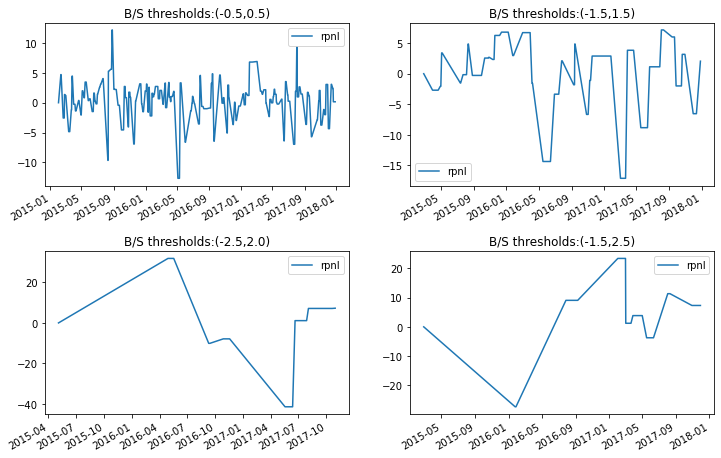

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt # Machine learning library used to create datasets and plots

fig, axes = plt.subplots(nrows=len(THRESHOLDS)//2, 
    ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
for i, (buy_threshold, sell_threshold) in enumerate(THRESHOLDS):
    engine.start(
        lookback_intervals=20,
        buy_threshold=buy_threshold,
        sell_threshold=sell_threshold
    )
    df_rpnls = engine.df_rpnl
    ax = axes[i // 2, i % 2]
    ax.set_title(
        'B/S thresholds:(%s,%s)' % 
        (buy_threshold, sell_threshold)
    )
    df_rpnls.plot(ax=ax)